# Castile and Leon: Crops

### Description:
TODO

### Author:
Sergio García Prado ([garciparedes.me](https://garciparedes.me))

## Setting up environment:

In [1]:
rm(list = ls())

In [2]:
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(RSocrata)
library(ca)
library(forcats)
library(reshape2)
library(lubridate)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Data Adquisition:

In [3]:
my.read.csv <- function(url, filename) {
    if (!file.exists(filename)) {
        write_csv(read.socrata(url), filename)
    }
    return(read_csv(filename))
}

In [4]:
crops.herbaceous <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/agu2-cspz.csv",
                               "./data/crops-herbaceous.csv")

Parsed with column specification:
cols(
  a_o = col_integer(),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  ocupaci_n_primera_regad_o = col_integer(),
  ocupaci_n_primera_secano = col_integer(),
  ocupaciones_asociadas_regad_o = col_character(),
  ocupaciones_asociadas_secano = col_character(),
  ocupaciones_posteriores_regad_o = col_character(),
  ocupaciones_posteriores_secano = col_character()
)


In [5]:
crops.woody <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/2vwa-si9n.csv",
                           "./data/crops-woody.csv")

Parsed with column specification:
cols(
  a_o = col_datetime(format = ""),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  n_total_arboles_diseminados = col_integer(),
  superficie_regad_o_en_producci_n = col_integer(),
  superficie_regad_o_que_no_pruduce = col_integer(),
  superficie_secano_en_producci_n = col_integer(),
  superficie_secano_que_no_pruduce = col_integer()
)


## Data Cleaning:

#### Remove Unnecesary Columns and Rename Interesting Columns

In [6]:
code.province.to.province <- function(code) {
    return(switch(as.character(code),
           "47" = "Valladolid",
           "24" = "León",
           "34" = "Palencia",
           "37" = "Salamanca",
           "9"  = "Burgos",
           "49" = "Zamora",
           "5"  = "Ávila",
           "42" = "Soria",
           "40" = "Segovia"))
}

In [7]:
crops.herbaceous.use <- crops.herbaceous %>%
    select(a_o, codigo_provincia:ocupaci_n_primera_secano) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           crop = cultivo, 
           crop.group = grupo_de_cultivo, 
           region = comarca, 
           town = municipio, 
           area.irrigation = ocupaci_n_primera_regad_o, 
           area.dry = ocupaci_n_primera_secano) %>%
    mutate(crop = factor(crop),
           crop.group = factor(crop.group),
           region = factor(region),
           town = factor(town),
           province = factor(sapply(code.province,code.province.to.province))) %>%
    rowwise() %>%
    mutate(area.total = sum(area.dry,area.irrigation, na.rm=TRUE)) %>%
    ungroup() %>%
    filter(area.total > 0) %>%
    select(-code.province)

In [8]:
crops.woody.use <- crops.woody %>%
    select(a_o, codigo_provincia:municipio,
           superficie_regad_o_en_producci_n,
           superficie_secano_en_producci_n) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           crop = cultivo, 
           crop.group = grupo_de_cultivo, 
           region = comarca, 
           town = municipio, 
           area.irrigation = superficie_regad_o_en_producci_n, 
           area.dry = superficie_secano_en_producci_n) %>%
    mutate(year = year(round(as.POSIXct(year), "days")),
           crop = factor(crop),
           crop.group = factor(crop.group),
           region = factor(region),
           town = factor(town),
           province = factor(sapply(code.province,code.province.to.province))) %>%
    rowwise() %>%
    mutate(area.total = sum(area.dry, area.irrigation, na.rm=TRUE)) %>%
    ungroup() %>%
    filter(area.total > 0) %>%
    select(-code.province)

In [9]:
crops.use <- rbind(crops.woody.use %>% mutate(crop.type = factor("woody")), 
                   crops.herbaceous.use %>% mutate(crop.type = factor("herbaceous")))

## Data Exploration:

#### View Data Sample

In [10]:
sample_n(crops.herbaceous.use, 10)

year,region,crop,crop.group,town,area.irrigation,area.dry,province,area.total
2015,PINARES,ESPARCETA,CULTIVOS FORRAJEROS,TALVEILA,6,21,Soria,27
2012,AREVALO-MADRIGAL,GIRASOL,CULTIV. INDUSTRIALES,ALDEASECA,202,5,Ávila,207
2015,SALDAÑA-VALDAVIA,REMOLACHA AZUCARERA,CULTIV. INDUSTRIALES,PEDROSA DE LA VEGA,8,0,Palencia,8
2010,CAMPO DE GOMARA,TRIGO,CEREALES GRANO,CIRIA,NA,428,Soria,428
2014,BENAVENTE Y LOS VALLES,GUISANTE SECO,LEGUMINOSAS GRANO,MORALES DE VALVERDE,1,22,Zamora,23
2012,CAMPOS-PAN,MELON,HORTALIZAS,ASPARIEGOS,NA,1,Zamora,1
2014,VITIGUDINO,TRITICALE,CEREALES GRANO,AHIGAL DE LOS ACEITEROS,0,53,Salamanca,53
2014,CUELLAR,GIRASOL,CULTIV. INDUSTRIALES,PINARNEGRILLO,12,74,Segovia,86
2014,LA SIERRA,PATATA MED. ESTACION,TUBERCULOS,MIRANDA DEL CASTAÑAR,1,NA,Salamanca,1
2014,AREVALO-MADRIGAL,CENTENO,CEREALES GRANO,BARROMAN,0,45,Ávila,45


In [11]:
summary(crops.herbaceous.use)

      year                         region                      crop      
 Min.   :2010   CAMPOS                :  7564   CEBADA           :12299  
 1st Qu.:2011   CUELLAR               :  7513   TRIGO            :11016  
 Median :2013   AREVALO-MADRIGAL      :  6109   AVENA            : 9966  
 Mean   :2013   CAMPOS-PAN            :  5951   GIRASOL          : 9803  
 3rd Qu.:2015   SALAMANCA             :  5723   CENTENO          : 9020  
 Max.   :2016   BENAVENTE Y LOS VALLES:  5280   VEZA PARA FORRAJE: 8116  
                (Other)               :111727   (Other)          :89647  
                crop.group             town        area.irrigation  
 CEREALES GRANO      :53292   CUELLAR    :   284   Min.   :   0.00  
 CULTIV. INDUSTRIALES:19925   TORO       :   264   1st Qu.:   1.00  
 CULTIVOS FORRAJEROS :32541   VALLADOLID :   252   Median :   4.00  
 FLORES              :   32   CANTALPINO :   243   Mean   :  31.29  
 HORTALIZAS          :12253   TORDESILLAS:   229   3rd Qu.:  20

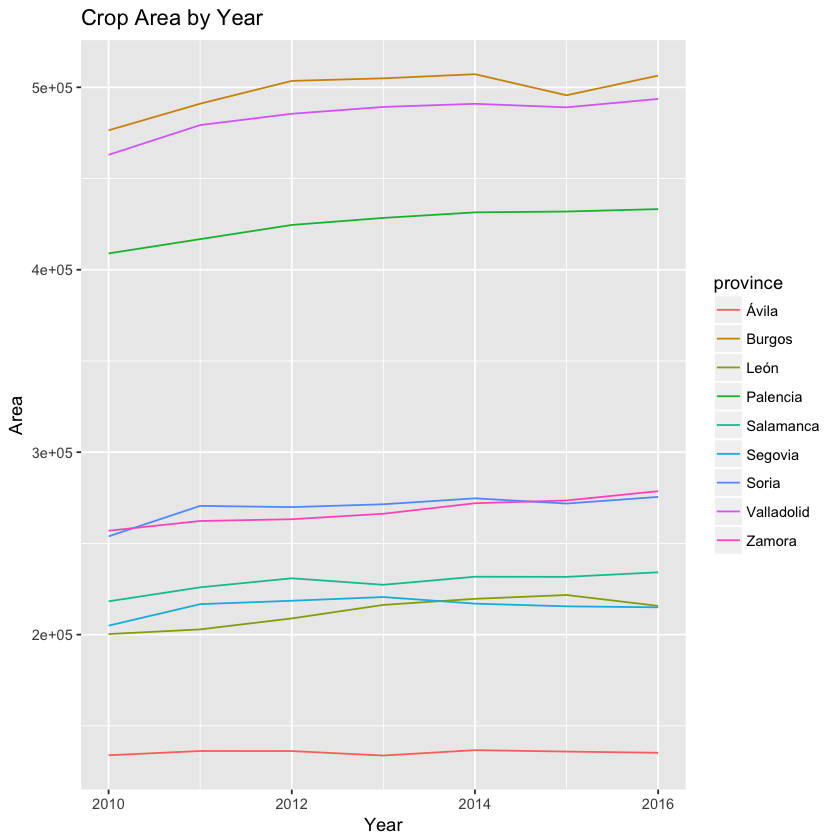

In [12]:
crops.herbaceous.use %>%
    select(year, area.total, province) %>%
    group_by(year, province) %>%
    summarise(area.total = sum(area.total, na.rm = TRUE)) %>%
    ggplot(aes(x=year, y = area.total, 
               group = province,
               col = province)) +
        labs(title = "Crop Area by Year", 
             x = "Year", y = "Area") + 
        geom_line()

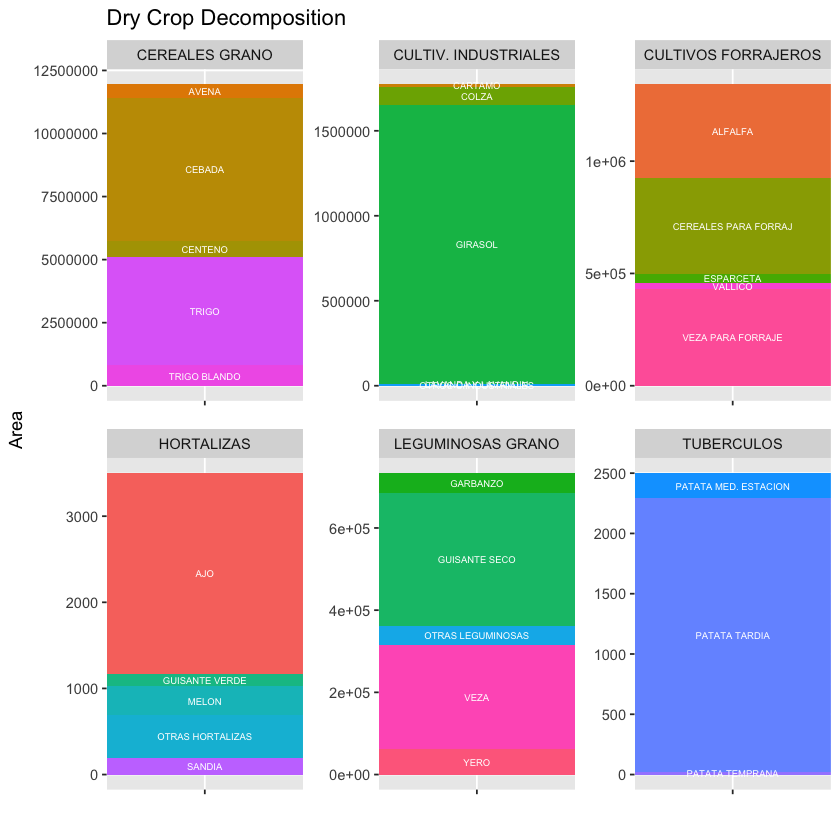

In [13]:
crops.herbaceous.use %>%
    select(crop, crop.group, area.dry) %>%
    filter(area.dry > 0) %>%
    group_by(crop.group, crop) %>%
    summarise(ocupacion = sum(area.dry, na.rm = TRUE)) %>%
    top_n(5, ocupacion) %>%
    ggplot(aes(x = "", y = ocupacion, fill = crop, label = crop)) + 
        geom_bar(width = 1, stat = "identity") +
        theme(legend.position='none') + 
        labs(title = "Dry Crop Decomposition", 
             x = "", y = "Area") + 
        facet_wrap( ~ crop.group, scales = "free", ncol=3)+ 
        geom_text(size = 2, position = position_stack(vjust = 0.5), 
                  colour="white") 

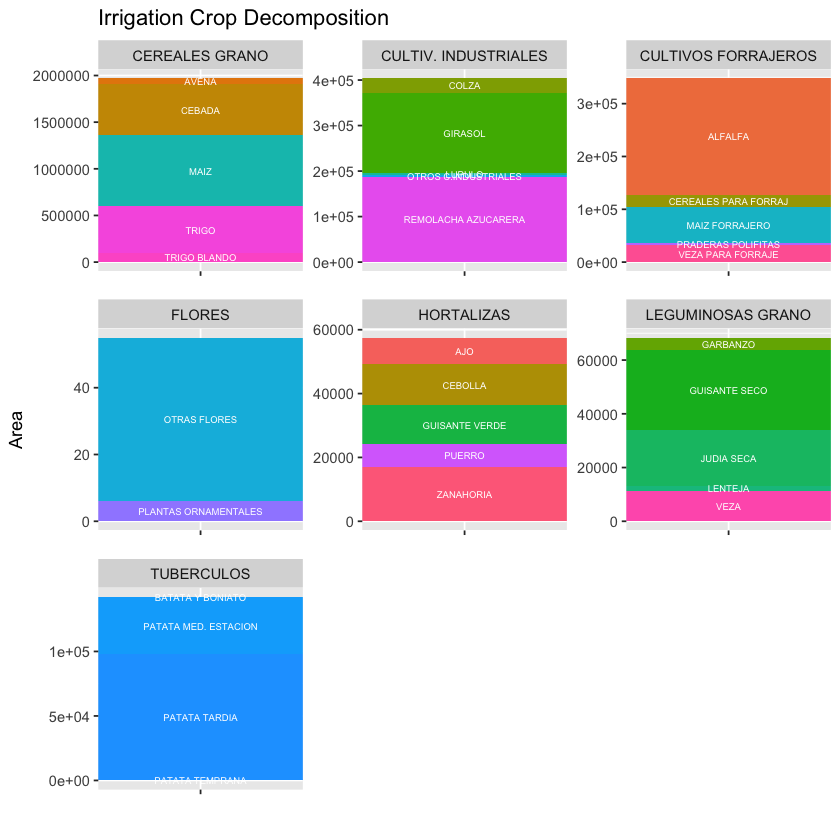

In [14]:
crops.herbaceous.use %>%
    select(crop, crop.group, area.irrigation) %>%
    filter(area.irrigation > 0) %>%
    group_by(crop.group, crop) %>%
    summarise(ocupacion = sum(area.irrigation, na.rm = TRUE)) %>%
    top_n(5, ocupacion) %>%
    ggplot(aes(x = "", y = ocupacion, fill = crop, label = crop)) + 
        geom_bar(width = 1 , stat="identity") +
        theme(legend.position='none') + 
        labs(title = "Irrigation Crop Decomposition", 
             x = "", y = "Area") +
        facet_wrap( ~ crop.group, scales = "free")+ 
        geom_text(size = 2, position = position_stack(vjust = 0.5), 
                  colour="white") 

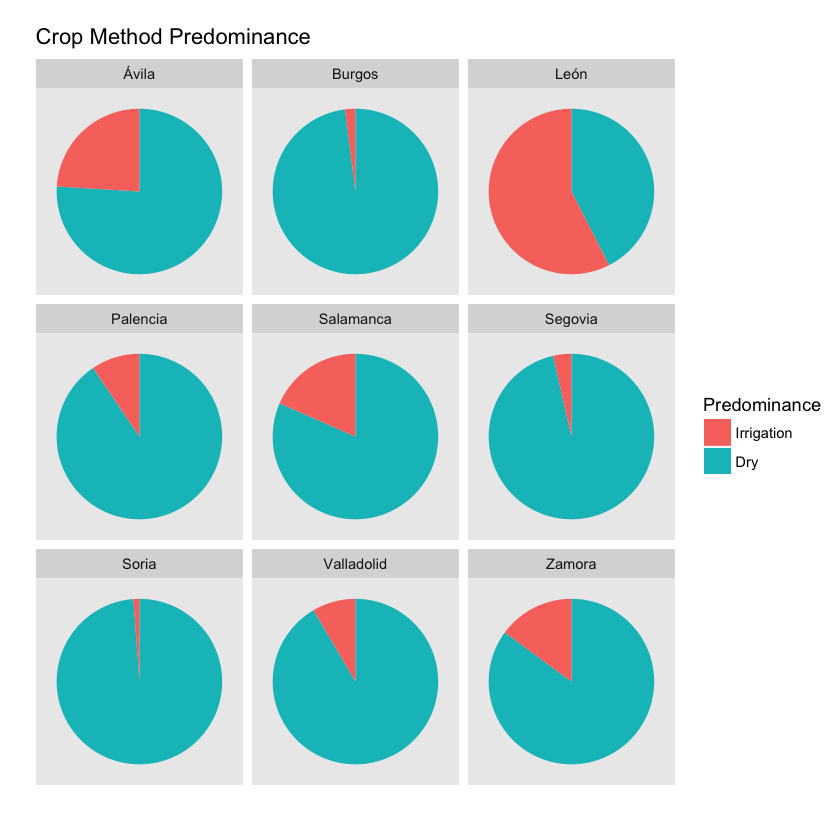

In [15]:
crops.herbaceous.use %>%
    select(town, area.irrigation, area.dry, province) %>%
    group_by(town, province) %>%
    summarise(area.irrigation.total = sum(area.irrigation, na.rm = TRUE),
              area.dry.total = sum(area.dry, na.rm = TRUE)) %>%
    group_by(province) %>%
    summarise(Irrigation = sum(area.irrigation.total > area.dry.total, na.rm = TRUE),
              Dry = sum(area.irrigation.total < area.dry.total, na.rm = TRUE)) %>%
    mutate(total = Irrigation + Dry,
          Irrigation = Irrigation / total,
          Dry = Dry / total) %>%
    select(-total) %>%
    melt(id.vars = "province") %>%
    ggplot(aes(x = "", y = value, fill = variable)) +
        geom_bar(stat = "identity", width = 1) +
        labs(title = "Crop Method Predominance", 
             x = "", y = "", fill = "Predominance") +
        coord_polar(theta = "y") + 
        facet_wrap(~province) +
    theme(axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid  = element_blank())

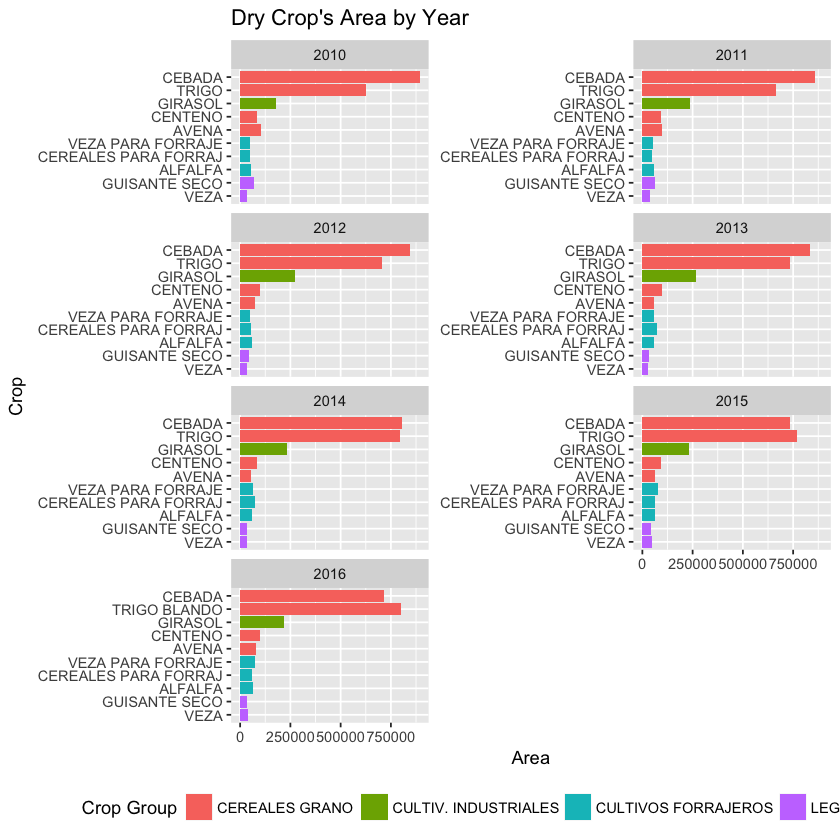

In [16]:
crops.herbaceous.use %>%
  select(crop, year, crop.group, area.dry) %>%
  filter(area.dry > 0) %>%
  group_by(crop.group, year, crop) %>%
  summarise(ocupacion = sum(area.dry, na.rm = TRUE)) %>%
  ungroup() %>%
  group_by(year) %>%
  top_n(10, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.group), stat = "identity") + 
    theme(legend.position='bottom') + 
    labs(title = "Dry Crop's Area by Year", 
         x = "Crop", y = "Area", fill = "Crop Group") +
    coord_flip() + 
    facet_wrap(~year, scales = "free_y", ncol = 2)

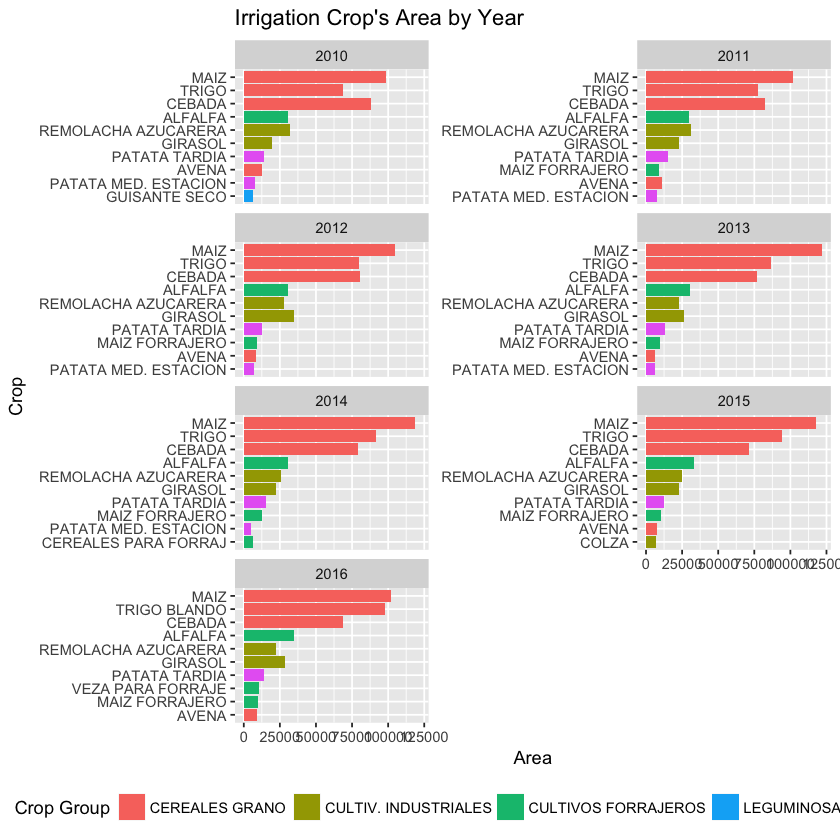

In [17]:
crops.herbaceous.use %>%
  select(crop, crop.group, year, area.irrigation) %>%
  group_by(crop.group, year, crop) %>%
  summarise(ocupacion = sum(area.irrigation, na.rm = TRUE)) %>%
  ungroup() %>%
  group_by(year) %>%
  top_n(10, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.group), stat = "identity") + 
    theme(legend.position='bottom') + 
    labs(title = "Irrigation Crop's Area by Year", 
         x = "Crop", y = "Area", fill = "Crop Group") +
    coord_flip() + 
    facet_wrap(~year, scales = "free_y", ncol = 2)

### Correspondence Analysis

In [18]:
crops.herbaceous.use.ca.dry <- crops.herbaceous.use %>%
    select(crop.group, province, area.dry) %>%
    filter(area.dry > 0) %>%
    xtabs(formula = area.dry ~ .,
          drop.unused.levels = TRUE) %>%
    ca()

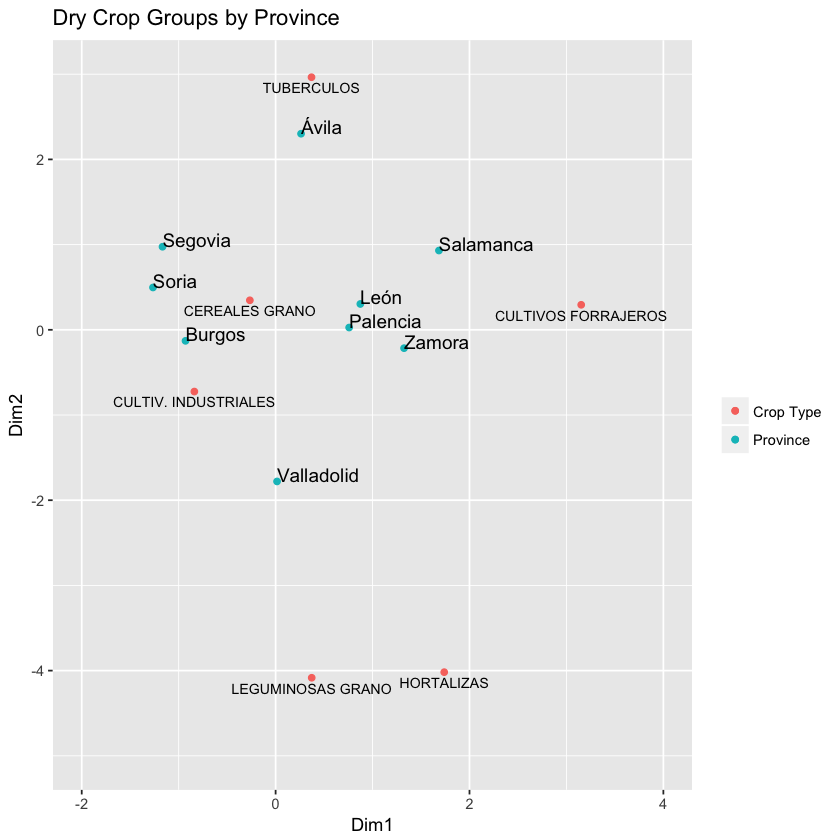

In [19]:
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    labs(title = "Dry Crop Groups by Province", 
         colour = "") +
    geom_point(data = as.data.frame(crops.herbaceous.use.ca.dry$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.herbaceous.use.ca.dry$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.herbaceous.use.ca.dry$rowcoord),
              label=rownames(crops.herbaceous.use.ca.dry$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.herbaceous.use.ca.dry$colcoord),
              label=rownames(crops.herbaceous.use.ca.dry$colcoord), 
              hjust=0, vjust=0, size = 4) +
    coord_cartesian(xlim = c(-2, 4), ylim = c(-5, 3)) 


In [20]:
crops.herbaceous.use.ca.irrigation <- crops.herbaceous.use %>%
    select(crop.group, province, area.irrigation) %>%
    filter(area.irrigation > 0) %>%
    xtabs(formula = area.irrigation ~ .,
          drop.unused.levels = TRUE) %>%
    ca()

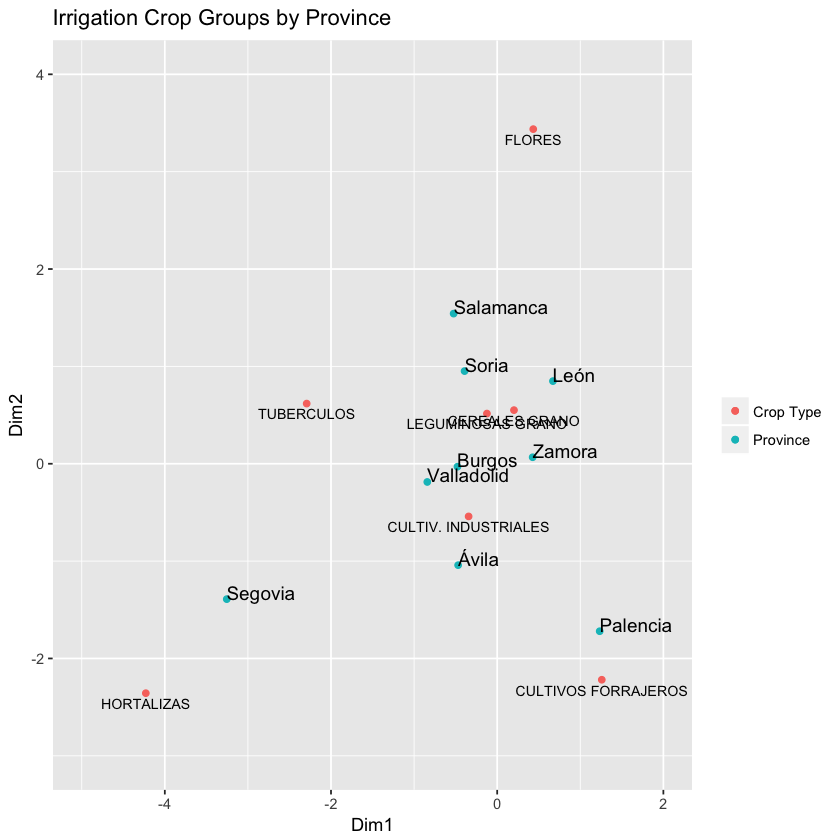

In [21]:
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    labs(title = "Irrigation Crop Groups by Province", 
         colour = "") +
    geom_point(data = as.data.frame(crops.herbaceous.use.ca.irrigation$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.herbaceous.use.ca.irrigation$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.herbaceous.use.ca.irrigation$rowcoord),
              label=rownames(crops.herbaceous.use.ca.irrigation$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.herbaceous.use.ca.irrigation$colcoord),
              label=rownames(crops.herbaceous.use.ca.irrigation$colcoord), 
              hjust=0, vjust=0, size = 4) +
    coord_cartesian(xlim = c(-5, 2), ylim = c(-3, 4)) 